## Hello everyone!
This is the code I used in a big-data project to visualise the ongoing data flows from this data set.
I want to give a massive "Thank you!" to @bwandowando for keeping the dataset up to date and managing it throughout all the errors over the last 4 month 

The project resulted in a Power-BI Dashboard which is sadly too large to publish, so I instead will give some final screenshots in a related discussion.
The code below is my processing timeline which consists of three main steps
- Preprocess the data 
        - I only kept english tweets, deleted hashtags at the end of the tweets, cleaned text overall, dropped duplicate tweets in a mannor that the tweet with most followers is kept
- Classify the emotion of every tweet
- Cluster the tweet's embeddings with UMAP and DBSCAN to achieve clusters of similar topics 
        - top 50 words are then put into a string and classified with a zero-shot-classifier
        
As you may notice while reading the code, the point of the pipeline is not to create appealing visualisations in the notebook, but to have all the necessary data to create nice visualisations in the dashboard later on. I am sure you can adjust the code a little or copy some snippets to display results in the notebook!

Since we have two different sections based on transformers, I recommend running with GPU.

If you have any questions, feedback or ideas, please reach out either via my profile or in the comments! Eager to learn :)

In [1]:
!pip install emot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 615.7 kB/s eta 0:00:00


In [2]:
#Imports & Setup
import warnings
warnings.filterwarnings("ignore")

import os
import re
import pandas as pd
import datetime 
import time
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#Note: I use a Doc2Vec, UMAP, DBSCAN combination to rebuild the idea from the nice package "Top2Vec"
#I achieved better results than displayed in this notebook using Top2Vec, however, was not able to follow the Top2Vec approach all the way through
#due to python-Version limitations on the platform this code was running on (Which run on Python 3.6.12 without having admin rights)
from gensim import corpora, models
import umap.umap_ as umap
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
import nltk
from sklearn.cluster import DBSCAN
from sklearn import metrics

import tensorflow as tf
import transformers
import datasets

import warnings
warnings.filterwarnings("ignore")
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO

#model for zero-shot-classifying topics (not fine-tuned, performs mediocrely on clusters)
classifier = transformers.pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device = 0)
#Misanthropy is to detect anti-putin tweets (as they are often just swear words like "F*** Putin"), we couldn't come up with a better tag for it
#Misanthropy works quite bad on the clustering approach, so you may leave it out.
clf_labels = ["Humanitarian help", "War operations", "Economy", "European politics", "Cryptocurrency and NFTs", "Popculture", "US Politics", "Misanthropy"]

#model for classifying the tweet's emotion (not fine-tuned, performs decently)
model = "j-hartmann/emotion-english-distilroberta-base"
emot = transformers.pipeline("text-classification", model = model, tokenizer = model, max_length = 512, device = 0, truncation = True)

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/294 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [3]:
#I used the kaggle API to download the whole dataset at once, this was due to the fact that everytime I tried to receive individual files I got served
#with the error 404. As the Dataset grew to 11GB by now, this is very uncomfortable with slow internet connection. To avoid doing this very often I executed this script
#daily with crontab, always receiving the file from two days back, to make sure the file is there already

#Chosen two days to have a more efficient pipeline that is not constantly downloading and deleting.
def file_date():
    """the file on may 21st will be labeled may20th; as such we need the day from two days ago in an MMDD format!"""
    today = datetime.datetime.today()
    file_month = "%s" %(today - datetime.timedelta(days=2)).month 
    file_day = "%s" %(today - datetime.timedelta(days=2)).day
    if len(file_day) == 1: return "0" + file_month + "0" + file_day
    else: return "0" + file_month + file_day

def file_name(): #only works for files after April 1st; before there was no uniform labeling of files
    """the file on may 21st will be labeled may20th; as such we need the day from two days ago in an MMDD format!"""
    return file_date() + "_UkraineCombinedTweetsDeduped.csv.gzip" #this is the name of all files AFTER april 1st

def remove_emoji(string):
    """removes emojis"""
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def prepare_text(series):
    """further preprocesses text again to achieve "super clean text" """
    dropwords = ["https", "amp", "t", "co", "u", "s", "ukraine", "ukrainerussiawar", "russian", "russia", "ukrainewar", "ukrainerussianwar", "russianukrainianwar", "ukraineunderattaсk", "ukrainerussianwar" "putin", "standwithukraine", "ukraine", "🇺🇦", "ukrainian"]
    #dropped many extra words that were very common
    data_stripped = []
    for i in series:
        text = i.lower() #remove upper case letters to allow grouping
        text = remove_stopwords(text)
        text = strip_punctuation(text) #remove all instances of . and : 
        text = strip_tags(text)
        text = strip_numeric(text) #may be dangerous, but lets test
        text = strip_multiple_whitespaces(text) #remove dupplicate spaces
        text = strip_short(text) #can be dangerous, but lets test
        text = remove_emoji(text)
        extra_strip = []
        for word in text.split():
            if word not in dropwords: extra_strip.append(word)
        text = " ".join(word for word in extra_strip)
        data_stripped.append(text)
    return data_stripped
    
def classify_emotion(df_unq):
    """classify the emotion of every individual tweet"""
    model = "j-hartmann/emotion-english-distilroberta-base"
    emot = transformers.TFAutoModelForSequenceClassification.from_pretrained(model)

    tokenizer = transformers.AutoTokenizer.from_pretrained(model)
    def tok_func(x): return tokenizer(x["cleaned_text"], truncation = True)

    df = df_unq[["cleaned_text"]]
    ds = datasets.Dataset.from_pandas(df)
    input = ds.map(tok_func, batched = True)

    data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer, padding = True, return_tensors="tf")
    tf_ds = input.to_tf_dataset(
        columns=["attention_mask", "input_ids"],
        shuffle=False,
        collate_fn=data_collator,
        batch_size=16,
    )

    classes = emot.predict(tf_ds)
    preds = pd.Series(np.argmax(classes[0], axis = 1)).map(emot.config.id2label)
    df_unq["emotion"] = preds.tolist()
    return df_unq 

def umap_reducer(embeddings):
    """reduced the embeddings to 2D with UMAP"""
    #hyperparameters were finetuned on three different days, overall these hyperparameters worked decent for all data files so far
    reducer = umap.UMAP(n_components=2, n_neighbors = 25, min_dist = 0.0, init = "random", metric = "cosine", random_state=0)
    umapped = reducer.fit_transform(embeddings)
    return umapped

def dbscan_cluster(umapped):
    """clusters UMAP reduced vectors with DBScan"""
    #hyperparameters finetuned on the same three days as umap
    db = DBSCAN(eps=0.075, min_samples=33, n_jobs = -1).fit(umapped)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    return labels

def recluster(df, iteration):
    """recluster the big clusters to achieve more nuanced results, basically repeats the whole topic part of the pipeline that happened so far"""
    threshold = df.shape[0] * 0.3
    counts_per_cluster = pd.Series(df.umap).value_counts()
    recluster = counts_per_cluster[counts_per_cluster > threshold]
    #take the big clusters
    df_recluster = df[df.umap.isin(recluster.index[:])]
    print(f"reclustering index {recluster}")
    
    #create new corpus and doc2vec 
    corpus_gen=[doc.split() for doc in df_recluster.cleaned_text]
    corpus_tagged = []
    for i, tokens in enumerate(corpus_gen):
        corpus_tagged.append(TaggedDocument(tokens, [i]))
    embeddings = [tagged_model.infer_vector(doc) for doc, doc_id in corpus_tagged]

    #reduce again with umap
    print("Reducing new Doc2Vec")
    reducer = umap.UMAP(n_components=2, n_neighbors = 25, min_dist = 0.0, init = "random", metric = "cosine", random_state=0)
    re_umapped = reducer.fit_transform(embeddings)

    #new clustering dependend of iteration
    print("Clustering again")
    db = DBSCAN(eps=0.075, min_samples= (round(25 / np.sqrt(iteration))), n_jobs = -1).fit(re_umapped)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    re_labels = db.labels_  

    #print reclustering results
    n_clusters_ = len(set(re_labels)) - (1 if -1 in re_labels else 0)
    n_noise_ = list(re_labels).count(-1)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    #make sure label numbers continue where they stopped before
    cur_max_clusters = max(list(set(df.umap)))
    new_labels = []
    for label in re_labels:
        if label != -1:
            new_labels.append(label + cur_max_clusters) 
        else:
            new_labels.append(label)
    df_recluster["umap_2"] = new_labels

    #overwrite existing big clusters
    df.umap.loc[df_recluster.index] = df_recluster.umap_2
    print(f"iteration {iteration} of reclustering complete")
    return df

def top50words_cluster(cluster_df, column):
    """return 50 most frequent words per cluster"""
    #put all tweets into one string and split it into list of words
    long_str = cluster_df[column].astype(str).str.cat(sep = " ").split(" ")
    word_arr = np.array(long_str).flatten()
    #drops all kind of mistakes like ";" or " "
    cleaned_arr = [word for word in word_arr if len(word) > 1]
    #get top 50 most common words; optimally, we would not only use the 50 most common but the top 50 most influential words!
    #I think this is the main difference in performance between my functions and the Top2Vec Package
    frequencies = nltk.FreqDist(cleaned_arr).most_common(50)
    freq_string = " ".join([frequencies[idx][0] for idx in range(len(frequencies))])
    return freq_string

def get_cluster_names(df):
    """classifies the clusters based on their top 50 words with zero-shot classification 
    and maps the result into the dataframe"""
    cluster_label = []
    for cluster_num in df.umap.sort_values().unique():
        cluster_df = df[df.umap == cluster_num]
        cluster_words = top50words_cluster(cluster_df, "super_clean_text")
        cluster_label.append([cluster_num, classifier(cluster_words, clf_labels)["labels"][0]])
        print(f"{cluster_num} out of {max(df.umap.unique())} labelled")
    
    #create dictionary from labels so we can map by key
    cluster_map = dict(cluster_label)
    #label -1 will always be Noise and shouldnt be updated 
    cluster_map.update({-1 : "Noise"})
    df["cluster_label"] = df.umap.map(cluster_map)
    return df

In [4]:
#Get data (not needed on kaggle)
#os.chdir("./") #your working dir where you download the data
# ---> Plan B: Download whole dataset and kill everything thats not new <---
# dont do this local! not good approach!!
#
#
#this is to remove the zip file which will cancel downloading in case it failed before (as long as zip is there download doesn't start)
#if os.path.isfile("./ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip") == True:
#    os.system("rm ./ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip")
#
#try:
#    api.dataset_download_files(dataset="bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows",
#                              unzip = True, force = False)
#    print("downloaded")
#                                 #important: as long as force = False, it will not keep duplicates
#except Exception:
#    print("couldn't download")

In [5]:
#Check if data exists and process the dataframe 
new_file = file_name()
print(f"trying to process {new_file}")

try: 
    start = time.time()
    #this does all the super-fast preprocessing that takes <10 secs for the whole dataframe
    #if this would run longer, we could also use pySpark for this part
    os.chdir("../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows")
    df = pd.read_csv(new_file, compression = "gzip", index_col = 0)
    print("df created")
    #we remove a lot of extra data, which is not necessarily good. 
    #In this case, however, it is not needed to keep them as they are stored on Kaggle as well
    df_en = df[df.language == "en"]
    df_en = df_en[["username", "followers", "totaltweets", "usercreatedts", "tweetcreatedts", "retweetcount", "text", "hashtags", "extractedts"]]
    df_unq = df_en.sort_values("followers").drop_duplicates(subset=["text"], keep= "last")

    #Clean text for classifications, wordcloud etc.
    clean_pattern = "https:\S+| @\w+|\\n|\\r" #remove all links, user-tags, new-lines completely
    cleaned = [re.sub(clean_pattern,"", text) for text in df_unq.text]
    pattern = "(\s#\w+)*$" #removes all hashtags at the end of a tweet
    no_endhash = [re.sub(pattern,"", text.rstrip()) for text in cleaned]
    pattern_mid = "#" #turns all hashtags in the middle of the sentence to normal words
    no_midhash = [re.sub(pattern_mid," ", text.rstrip()) for text in no_endhash]
    df_unq["cleaned_text"] = no_midhash
    #Get Hashtags from the weird string-list-dictionary that bwandowando left us with
    hashtags_pattern = "(?<='text': ')\w+"
    hashtags = [re.findall(hashtags_pattern, row) for row in df_unq.hashtags]
    hashtags_str = [", ".join([tag for tag in arr]) for arr in hashtags]
    df_unq["hashtags"] = hashtags_str

    #Clean text for writing csvs (kill all \n), else the writing and reading will not work as smooth
    pattern_newlines = "\\n|\\r"
    new_text = [re.sub(pattern_newlines, " ", text) for text in df_unq.text]
    df_unq["text"] = new_text

    #preparation for clustering, remove all kind of stop words
    df_unq["super_clean_text"] = prepare_text(df_unq.cleaned_text)
    #drops further rows that become identical after creating super clean text
    df_unq = df_unq.sort_values("followers").drop_duplicates(subset=["super_clean_text"], keep= "last")

    df_unq = classify_emotion(df_unq)

    #create corpus and doc2vec model for embeddings
    print("start embedding")
    corpus_gen=[doc.split() for doc in df_unq.cleaned_text] #we use cleaned text because the embeddings wants semantics
    corpus_tagged = []
    for i, tokens in enumerate(corpus_gen):
        corpus_tagged.append(TaggedDocument(tokens, [i]))
    tagged_model = Doc2Vec(corpus_tagged, vector_size = 100, window = 8, negative = 5, workers = 36, epochs = 20) 
    embeddings = [tagged_model.infer_vector(doc) for doc, doc_id in corpus_tagged]
    print("embeddings generated")

    #reduce dimensions with umap
    umapped = umap_reducer(embeddings) 

    #put cluster axis to dataframe so we can plot them in powerBI
    df_unq["cluster_x"] = umapped[:,0]
    df_unq["cluster_y"] = umapped[:,1]

    #assign all rows to a cluster
    df_unq["umap"] = dbscan_cluster(umapped)

    #Check if there are any too big clusters (~ 30% of the df size)
    threshold = df_unq.shape[0] * 0.3
    counts_per_cluster = pd.Series(df_unq.umap).value_counts()
    big_clusters = counts_per_cluster[counts_per_cluster > threshold]

    #recluster until biggest clusters are smaller, this will help finding more sub topics
    iteration = 1
    while big_clusters.shape != (0,) and iteration < 3: #max 2 iterations in case the cluster is actually that big
        df_unq = recluster(df_unq, iteration)
        counts_per_cluster = pd.Series(df_unq.umap).value_counts()
        big_clusters = counts_per_cluster[counts_per_cluster > threshold]

        iteration += 1

    #give the cluster labels with zero-shot classification
    print("labeling clusters")
    df_unq = get_cluster_names(df_unq)

    #file management
    os.chdir("/kaggle/working/")
    new_file =  re.sub(".csv.gzip", "_processed.csv", new_file)
    df_unq.to_csv(new_file, index = False)
    print(f"file: {new_file} is done, took {round(time.time() - start) / 60} minutes")
except FileNotFoundError: print("not available yet")

trying to process 0728_UkraineCombinedTweetsDeduped.csv.gzip
df created


Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

2022-07-30 06:49:32.143880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 06:49:32.145049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 06:49:32.145715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 06:49:32.146505: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

  0%|          | 0/26 [00:00<?, ?ba/s]

2022-07-30 06:49:42.602697: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


start embedding
embeddings generated
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Estimated number of clusters: 66
Estimated number of noise points: 12022
reclustering index -1    12022
Name: umap, dtype: int64
Reducing new Doc2Vec
Clustering again
Estimated number of clusters: 24
Estimated number of noise points: 11018
iteration 1 of reclustering complete
reclustering index -1    11018
Name: umap, dtype: int64
Reducing new Doc2Vec
Clustering again
Estimated number of clusters: 93
Estimated number of noise points: 7850
iteration 2 of reclustering complete
labeling clusters
-1 out of 180 labelled
0 out of 180 labelled
1 out of 180 labelled
2 out of 180 labelled
3 out of 180 labelled
4 out of 180 labelled
5 out of

<AxesSubplot:xlabel='cluster_x', ylabel='cluster_y'>

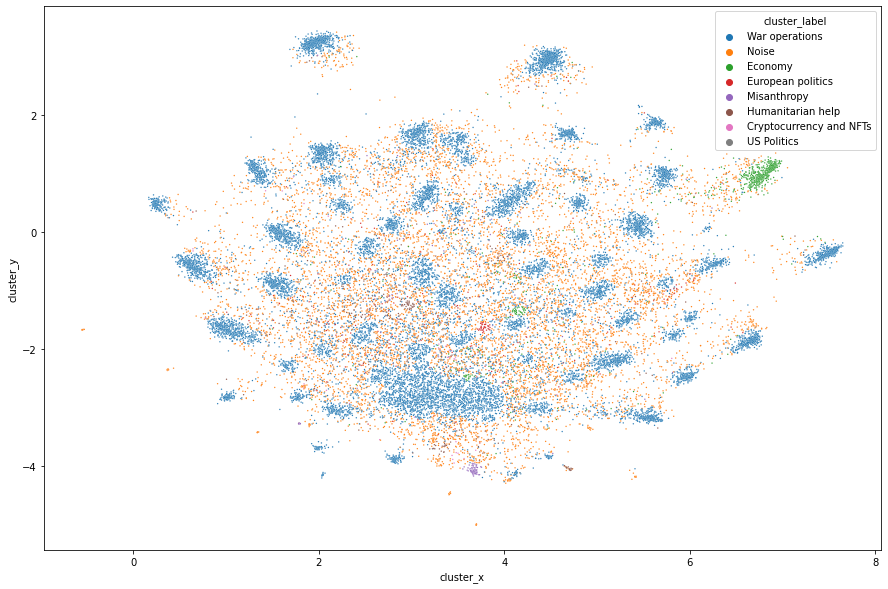

In [6]:
#example for the clustering scatter plot, we also do have a lot of noise today
plt.figure(figsize = (15,10))
sns.scatterplot(x = "cluster_x", y = "cluster_y", data = df_unq, s = 2, hue = "cluster_label")

#since the transformers are not fine tuned and there are many tweets about war, sadly, most of the tweets are labeled as War Operations
#with a fine tuned transformer this would be more balanced
#another thing helping this would possibly be using transformer embeddings over doc2vec, using 50 most important instead of 50 most common words (maybe try it)

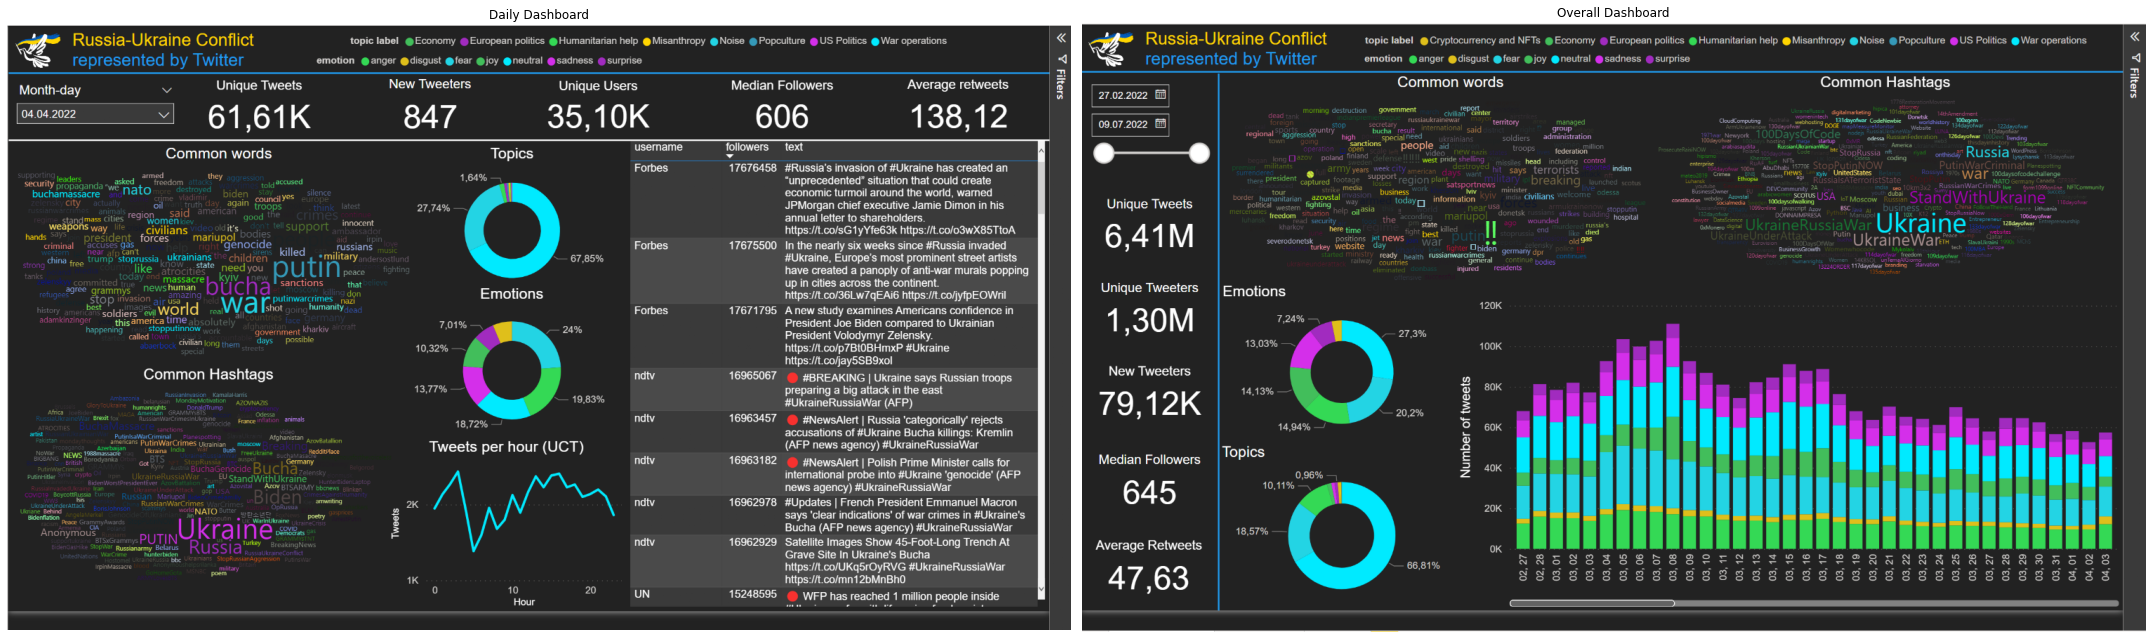

In [7]:
#this is how the dashboard looks in the end 
import matplotlib.image as mpimg
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (30,20))
daily = mpimg.imread(r"../input/dashboardukrainepictures/daily.png")
ax1.imshow(daily)
ax1.axis('off')
ax1.set_title("Daily Dashboard")
overall = mpimg.imread(r"../input/dashboardukrainepictures/overall.png")
ax2.imshow(overall)
ax2.axis('off')
ax2.set_title("Overall Dashboard")
plt.tight_layout()